# 05. Areal Interpolation

Let's create prototypes for the types of areal interpolation that we want (right now, just weighted is okay).

# Prepare dummy data

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon

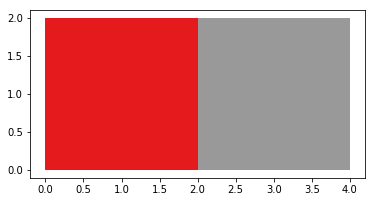

In [2]:
sq1 = Polygon([(0, 0), (0, 2), (2, 2), (2, 0)])
sq2 = Polygon([(2, 0), (2, 2), (4, 2), (4, 0)])

inputs = gpd.GeoDataFrame(geometry=[sq1, sq2])
inputs['area'] = inputs.area
inputs.plot(cmap='Set1');

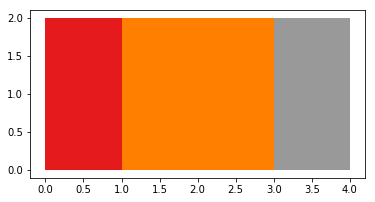

In [3]:
sq1 = Polygon([(0, 0), (0, 2), (1, 2), (1, 0)])
sq2 = Polygon([(1, 0), (1, 2), (3, 2), (3, 0)])
sq3 = Polygon([(3, 0), (3, 2), (4, 2), (4, 0)])

outputs = gpd.GeoDataFrame(geometry=[sq1, sq2, sq3])
outputs['area'] = outputs.area
outputs.plot(cmap='Set1');

# Weighted Areal Interpolation (a.k.a. *overlay*)

## Values

In [4]:
inputs['value'] = [1, 2]
outputs['value'] = [0.5, 1.5, 1]

In [5]:
inputs['density'] = inputs['value'] / inputs['area']
outputs['density'] = outputs['value'] / outputs['area']

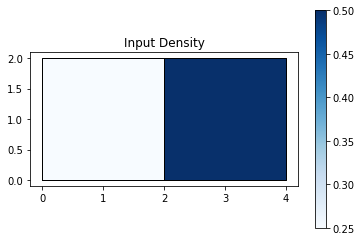

In [6]:
inputs.plot(column='density', legend=True, cmap='Blues', edgecolor='black')
plt.title('Input Density');

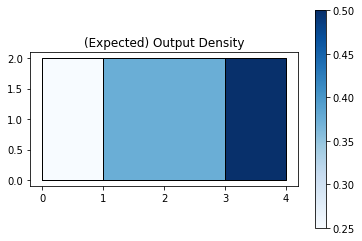

In [7]:
outputs.plot(column='density', legend=True, cmap='Blues', edgecolor='black')
plt.title('(Expected) Output Density');

## Function

In [8]:
def weighted_areas(source, target):
    # TODO equal area

    # checks
    assert source.crs == target.crs
    assert source.unary_union.contains(target.unary_union)

    source_values = source.select_dtypes(include='number')
    var_names = source_values.columns
    source_geoms = source.geometry
    target_geoms = target.geometry

    # preprocess (speed)
    target_union = target_geoms.unary_union
    source_geoms = source_geoms[source_geoms.intersects(target_union)]

    # algorithm
    target_values = []
    for t_id, t_geom in target_geoms.iteritems():        
        # calculate target value (actually an array of values)
        t_value = pd.Series(0, index=var_names)
        for s_id, s_geom in source_geoms.iteritems():
            if t_geom.intersects(s_geom):
                intersect = t_geom.intersection(s_geom)
                ratio = intersect.area / s_geom.area
                s_value = source_values.loc[s_id]
                t_value += s_value * ratio
                
        t_value.name = t_id
        target_values.append(t_value)

    # target_values is already in the same order as target_geoms
    return gpd.GeoDataFrame(
        target_values,
        geometry=target_geoms,
        crs=target_geoms.crs,
    )

In [9]:
source = inputs.copy()
target = outputs.geometry.copy()
result = weighted_areas(source, target)  # works nice
result

,area,value,density,geometry
0,2.0,0.5,0.125,"POLYGON ((0 0, 0 2, 1 2, 1 0, 0 0))"
1,4.0,1.5,0.375,"POLYGON ((1 0, 1 2, 3 2, 3 0, 1 0))"
2,2.0,1.0,0.250,"POLYGON ((3 0, 3 2, 4 2, 4 0, 3 0))"


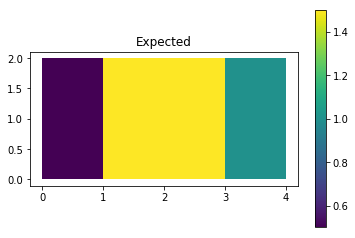

In [10]:
outputs.plot(column='value', legend=True)
plt.title('Expected');

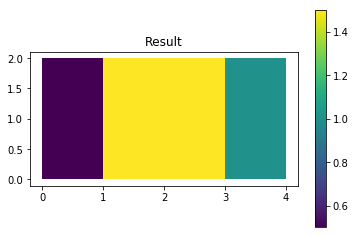

In [11]:
result.plot(column='value', legend=True)
plt.title('Result');